In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [2]:
data = pd.read_csv('Data\output.csv')

# Data description

Data was taken from the Center for Disease Control and Prevention's Community Health Status Indicators to Combat Obesity, Heart Disease, and Cancer dataset. The dataset includes measures taken for all counties in the USA and was released on May 1, 2010. 

Variables of interest will include those related to community health and community health centers.

In [3]:
data.head()

,id,chsi_state_abbr,population_size,population_density,poverty,age_19_under,age_19_64,age_65_84,age_85_and_over,no_exercise,obesity,smoker,diabetes,community_health_center_ind
0,1,AL,48612,82,10.4,26.9,62.3,9.8,0.9,27.8,24.5,26.6,14.2,1
1,2,AL,162586,102,10.2,23.5,60.3,14.5,1.8,27.2,23.6,24.6,7.2,1
2,3,AL,28414,32,22.1,24.3,62.5,11.6,1.6,-1111.1,25.6,17.7,6.6,1
3,4,AL,21516,35,16.8,24.6,63.3,10.9,1.2,-1111.1,-1111.1,-1111.1,13.1,1
4,5,AL,55725,86,11.9,24.5,62.1,12.1,1.3,33.5,24.2,23.6,8.4,2


In [10]:
#Replace missing data with Nan values
#Leave NaN values as there are over 1000 rows with a NaN value in one of the columns
data = data.replace([-1111.1, -2222.2], np.nan)

#Replace community indicator with Yes and No for easier interpretation
data.loc[:,'community_health_center_ind'] = data.community_health_center_ind.replace([1,2],['No','Yes'])

The first step was to create a pairplot of health variables to understand the relationships and distributions of these data.

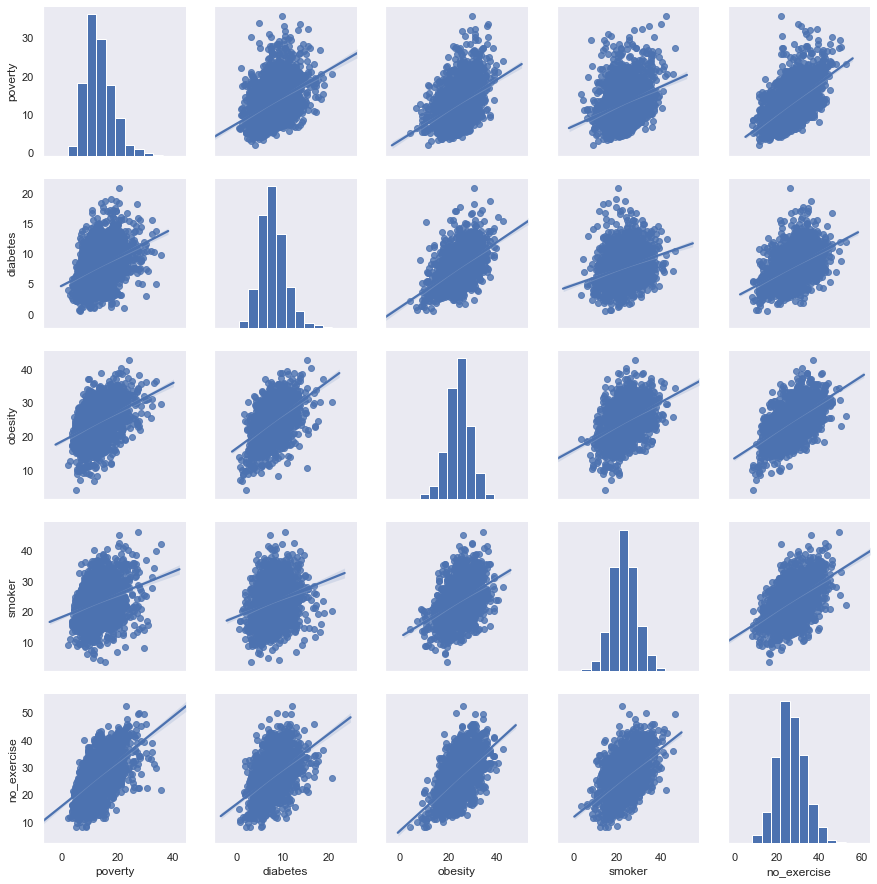

In [11]:
sns.pairplot(data.loc[:,('poverty','diabetes','obesity','smoker', 'no_exercise')], 
             kind='reg',
            dropna=True)
plt.show()

There seems to be consistently positive relationships between poverty, diabetes, obesity, smoking, and a lack of exercise. The next step will be to determine if there is evidence to suggest that community health centers have any impact on these variables.

First, I will get the counts of counties with and without community health centers

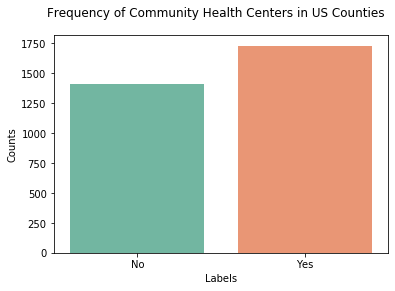

In [6]:
healthcenters_df = pd.DataFrame(list(data.groupby('community_health_center_ind').size()), columns=['Counts'])
healthcenters_df['Labels'] = ['No','Yes']

sns.barplot(x='Labels',y='Counts', data=healthcenters_df, palette='Set2')
plt.suptitle('Frequency of Community Health Centers in US Counties')
plt.show()

Second, I will determine if there are differences between counties with and without health centers

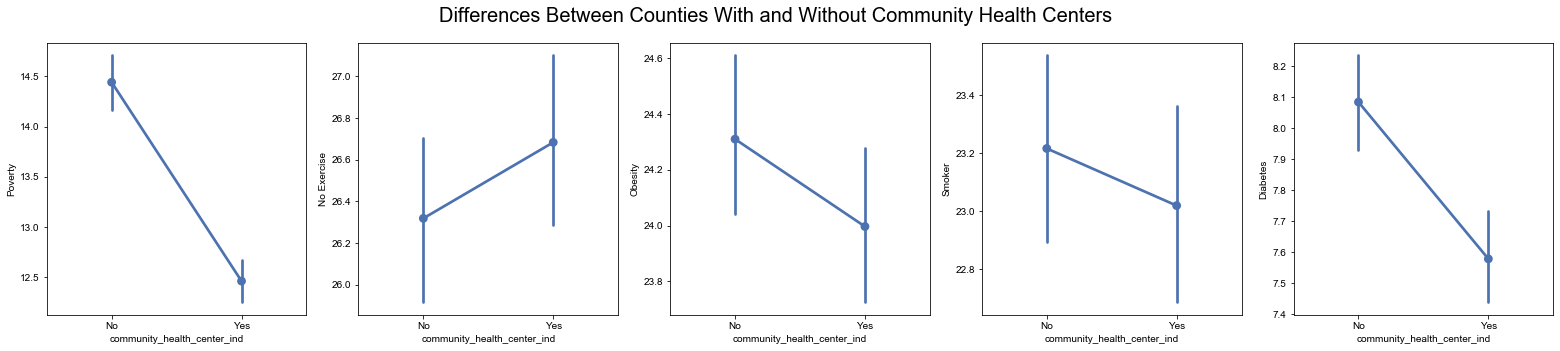

In [7]:
fig, axes = plt.subplots(1,5,figsize=(27,5))

fig.suptitle('Differences Between Counties With and Without Community Health Centers', fontsize=20)
sns.set(style='dark')

sns.pointplot(y='poverty', x='community_health_center_ind', data=data, ax=axes[0])
axes[0].set_ylabel('Poverty')

sns.pointplot(y='no_exercise', x='community_health_center_ind', data=data, ax=axes[1])
axes[1].set_ylabel('No Exercise')

sns.pointplot(y='obesity', x='community_health_center_ind', data=data, ax=axes[2])
axes[2].set_ylabel('Obesity')

sns.pointplot(y='smoker', x='community_health_center_ind', data=data, ax=axes[3])
axes[3].set_ylabel('Smoker')

sns.pointplot(y='diabetes', x='community_health_center_ind', data=data, ax=axes[4])
axes[4].set_ylabel('Diabetes')

plt.show()

These data suggest that the counties with community health centers had lower rates of obesity, smoking, diabetes, and poverty. Surprisingly, it appears that a lack of exercise was greater in communities with health centers. However, the point plots suggest that the only significant differences are in the poverty and diabetes variables. To confirm these findings I will calculate 2-sample ttests for the groups.

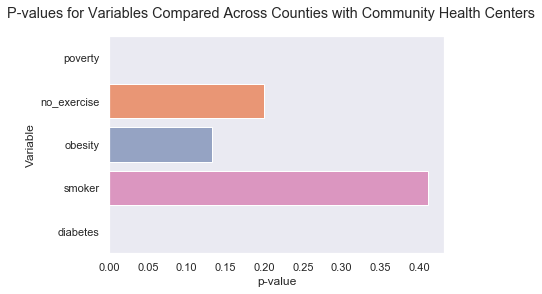

In [8]:
test_variables = ['poverty', 'no_exercise', 'obesity', 'smoker', 'diabetes']
test_results = []

#Store ttest results in the test_results list for each test variable between counties w/ and w/o health centers

for i in range(len(test_variables)):
    test_results.append(list(stats.ttest_ind(data.loc[data.community_health_center_ind == 'No',test_variables[i]],
        data.loc[data.community_health_center_ind == 'Yes',test_variables[i]], 
        nan_policy='omit',
        equal_var=False)))
    
#Extract p-values from test_results list, create DataFrame for barplot
p = []
for test in test_results:
    p.append(test[1])

test_df = pd.DataFrame()
test_df['Variable'] = test_variables
test_df['p-value'] = p

sns.barplot(y='Variable', x='p-value', data=test_df, palette='Set2')
plt.suptitle('P-values for Variables Compared Across Counties with Community Health Centers')
plt.show()

The results of the ttests indicate that the only significant differences between groups were for the poverty and diabetes variables as suggested by the point plots. These findings suggest that there is ~2% less poverty in counties with health centers and that there is a ~0.5% less prevalence of diabetes in counties with health centers. Next I will calculate the estimated effect of these differences on a county by county basis.

To calculate the absolute effect size for poverty and diabetes, I will compute the differences of means for diabetes and poverty between county groups (a percentage). Then multiply the differences of means by the median number of people in all counties.

In [9]:
#Due to the presence of extreme values in county pop size, I will use median as the estimate of central tendency
median_county_pop = (data['population_size'].median())

#Calculating the differences in means for poverty and diabetes
mean_diff_poverty = data.loc[data.community_health_center_ind == 'No', 'poverty'].mean()-data.loc[data.community_health_center_ind == 'Yes', 'poverty'].mean()
mean_diff_diabetes = data.loc[data.community_health_center_ind == 'No', 'diabetes'].mean()-data.loc[data.community_health_center_ind == 'Yes', 'diabetes'].mean()

#Multiplying the differences by median population to estimate the number of people affected
num_affected_poverty = math.floor(median_county_pop*mean_diff_poverty*.01)
print('The estimated difference from community health centers on poverty: '+ str(num_affected_poverty) + ' people')

num_affected_diabetes = math.floor(median_county_pop*mean_diff_diabetes*.01)
print('The estimated difference from community health centers on diabetes: '+ str(num_affected_diabetes) + ' people')

The estimated difference from community health centers on poverty: 500 people
The estimated difference from community health centers on diabetes: 127 people


# Hypothesis

Implementing community health centers in impoverished counties will reduce poverty prevalence, diabetes prevalence, and improve community health.

# Rollout Plan

There are currently 1411 counties in the US without health centers. Testing will include a proof of concept period where 14 counties of high poverty rates (1% of population) will be chosen at random to receive a center. Testing will focus on measureable changes in physiological and socioeconomic variables to better understand the impact these health centers have on communities. All testing will be conducted by trained staff at the health centers and measured on members and visitors of the health centers. 

Physiological variables of interest will include height, weight, blood pressure, IGF1, fasting blood glucose, dietary recall, smoking recall, and physical activity recall. 

Socioeconomic variables of interest will focus on both employees, patients, and the county. These will include # employees, average salary of employees, race/ethnicity, age, self-reported satisfcation with the center, county employment rate, and county poverty prevalence. 

Following a 1 year period after the implementation of the health centers, data will be collected and analyzed. If positive differences are found, success of these health centers will largely fall into one of three categories:

    1. Health centers have a significant impact on community health but not socioeconomics
    2. Health centers have a significant impact on socioeconomics but not community health
    3. Health centers have a significant impact on both community health and socioeconomics

If success is categorized into categories 1 or 2, implementation plans will be created to aid future counties that are interested in creating a community health center. If success is categorized into category 3, the Community Health Center Foundation will be created to provide grants for the implementation of community health centers throughout the US. 